In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
import mdtraj as md
from sklearn.pipeline import Pipeline
from msmbuilder.io import load_trajs, load_meta, preload_tops, load_generic
from msmbuilder.feature_extraction import DihedralFeaturizer
from msmbuilder.feature_selection import VarianceThreshold
from msmbuilder.preprocessing import RobustScaler
from msmbuilder.decomposition import tICA
import numpy as np

## Load data

In [3]:
def get_timings(meta):
    frames_tot = meta['nframes'].sum()
    n_frames = meta['nframes'].unique()
    assert (len(n_frames) == 1, 'Different trajectory lengths')
    n_frames = n_frames[0]
    dt = meta['step_ps'][0]
    to_ns = dt/1000
    t_max = n_frames*to_ns
    return to_ns, t_max, frames_tot


def traj_load(irow):
    i, row = irow
    traj = md.load(row['traj_fn'], top=tops[row['top_fn']])
    return i, traj


<ipython-input-3-b7f0c528c48c>:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (len(n_frames) == 1, 'Different trajectory lengths')


In [4]:
meta = load_meta('meta.pandas.pickl')
tops = preload_tops(meta)
trajs = [md.load(row['traj_fn'], top=tops[row['top_fn']], stride=1) 
         for i, row in meta.iterrows()]

## Get internal coordinates

In [5]:
bonds = load_generic('proc_traj/2agy_as-1_bonds.pickl')
angles = load_generic('proc_traj/2agy_as-1_angles.pickl')
dihedrals = load_generic('proc_traj/2agy_as-1_dihedrals.pickl')

## Featurize


In [6]:
def compute_dihedrals(traj, indices):
    dihedrals = md.compute_dihedrals(traj, indices=indices)
    dihedrals = np.concatenate((np.cos(dihedrals), np.sin(dihedrals)), axis=1)
    return dihedrals

def compute_angles(traj, indices):
    angles = md.compute_angles(traj, angle_indices=indices)
    angles = np.concatenate((np.cos(angles), np.sin(angles)), axis=1)
    return angles



In [7]:
from msmbuilder.feature_extraction import FunctionFeaturizer, AtomPairsFeaturizer
from msmbuilder.feature_selection import FeatureSelector

dihedrals_feat = FunctionFeaturizer(compute_dihedrals, func_args={'indices': dihedrals})
angles_feat = FunctionFeaturizer(compute_angles, func_args={'indices': angles})
bonds_feat = AtomPairsFeaturizer(pair_indices=bonds, periodic=True)


In [8]:
features = FeatureSelector([('bonds', bonds_feat), ('angles', angles_feat), ('dihedrals', dihedrals_feat)], 
                         which_feat=['angles'])
featurize = Pipeline([('features', features), ('variance', VarianceThreshold()), ('scaling', RobustScaler())])
to_ns, t_max, frames_tot = get_timings(meta)


In [9]:
def get_max_gap(evs, which=0):
    """
    returns n = number of components and spectral gap
    """
    ratios = evs[:-1]-evs[1:]
    return (np.argsort(ratios)[::-1][which]+1, ratios[np.argsort(ratios)[::-1][which]])

## Choose tICA parameters

In [ ]:
all_features = ['angles'] #, 'bonds', 'dihedrals', ['angles', 'bonds'], ['angles', 'dihedrals'], ['bonds', 'dihedrals'], 
                #['bonds', #'dihedrals', 'angles']]

for feature in all_features:
    featurize.set_params(features__which_feat=feature)
    print('Running {}'.format(feature))
    featurize.fit(trajs)
    ftrajs = featurize.transform(trajs)
    lags = np.arange(int(10/to_ns), int(51/to_ns), int(10/to_ns))
    n_comps = 10
    eigenvalues = np.zeros((lags.shape[0],n_comps))
    gaps = np.zeros(lags.shape[0])
    comps = np.zeros(lags.shape[0])
    for idx, lag in enumerate(lags):
        print('\t running lag {}'.format(lag))
        tica = tICA(n_components=n_comps, lag_time=lag, kinetic_mapping=True)
        tica.fit(ftrajs)
        evs = tica.eigenvalues_
        eigenvalues[idx] = evs
        n, gap = get_max_gap(evs)
        gaps[idx] = gap
        comps[idx] = n

    opt_idx = np.argmax(gaps)
    opt_gap = gaps[opt_idx]
    opt_comp = int(comps[opt_idx])
    opt_lag = lags[opt_idx]
    print('\t{0} has gap: {1}, n_components: {2}, with lag: {3}'.format(feature, opt_gap, opt_comp, opt_lag*to_ns))

## Do dimensionality reduction

In [35]:
featurize.set_params(features__which_feat='angles')
featurize.fit(trajs)
ftrajs = featurize.transform(trajs)
tica = tICA(n_components=1, lag_time=int(50/to_ns))
ttrajs = tica.fit_transform(ftrajs)

In [36]:
txx = np.concatenate(ttrajs)

In [37]:
txx1 = np.concatenate(ttrajs[::2])
txx2 = np.concatenate(ttrajs[1::2])


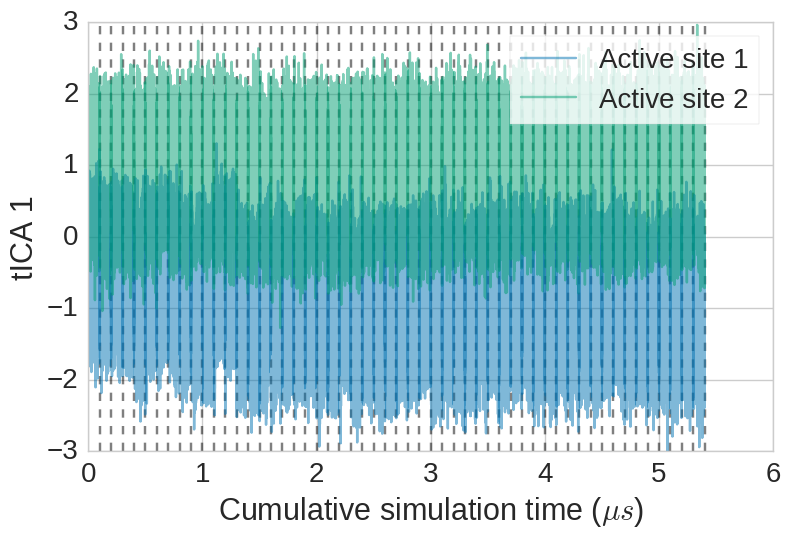

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_palette('colorblind', 2)
t = np.arange(txx1.shape[0])*to_ns/1000
n_comps = 1
n_frames = int(t_max/to_ns)
stride=1
space=1
sns.set_style('whitegrid')

with sns.plotting_context('notebook', font_scale=2):
    fig, axes = plt.subplots(nrows=n_comps, sharex=True)
    for i in range(n_comps):
        if n_comps > 1:
            ax = axes[i]
        else:
            ax = axes
        for k in range(txx1.shape[0]//n_frames):
            start, stop = k*n_frames, min(frames_tot, (k+1)*n_frames)
            times = t[start:stop:stride]
            ax.plot(times, txx1[start:stop:stride, i], label='Active site 1', alpha=0.5)
            ax.plot(times, txx2[start:stop:stride, i], label='Active site 2', alpha=0.5)
            ax.vlines(x=times[-1], ymin=-3,ymax=3, color='k', linestyle='--', alpha=0.5)
            ax.set_ylabel('tICA {}'.format(i+1))
            ax.set_xlabel('Cumulative simulation time ($\mu s$)')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], frameon=True, framealpha=0.8)
    ax.set_ylim((-3,3))
plt.tight_layout()
plt.savefig('tICA_Trajectory.pdf')

In [39]:
from msmbuilder.cluster import MiniBatchKMeans
cluster = MiniBatchKMeans(n_clusters=int(np.sqrt(frames_tot)))
ctrajs = cluster.fit_transform(ttrajs)

In [28]:
# print(len(ctrajs))
split=20
trajs_idx = []
for i in range(len(ctrajs)//split+1):
    print(i,min(len(ctrajs), (i+1)*split))
    trajs_idx.append(min(len(ctrajs), (i+1)*split))
print(trajs_idx)

0 20
1 40
2 60
3 80
4 100
5 108
[20, 40, 60, 80, 100, 108]


In [40]:
to_mu = to_ns/1000
n = len(trajs_idx)*2
cols = sns.color_palette('Blues', n)
print(trajs_idx)
with sns.plotting_context('notebook', font_scale=2):
    sns.set_style('whitegrid')
    fig, ax = plt.subplots()

    for jdx, traj_idx in enumerate(trajs_idx):
        txx = np.concatenate(ttrajs[:traj_idx])
        z,bins = np.histogram(txx[:,0],bins=200)
        print(traj_idx)
        time = traj_idx*n_frames*to_mu/(2.)
        F = -np.log(z)

        ax.plot(bins[1:], F, lw='2', c=cols[int(n/2)+jdx], label='{0:4.1f} $\mu s$'.format(time))
        ax.set_xlim((-2,2))
        ax.set_ylim((-10,-2))

        ax.set_ylabel('Free energy ( $kT$ )')
        ax.set_xlabel('tICA component 1')
#     handles, labels = ax.get_legend_handles_labels()
    ax.legend(frameon=True, framealpha=0.8, ncol=2, fontsize=15)
plt.savefig('tICA_FreeEnergy.pdf')

NameError: name 'trajs_idx' is not defined

In [ ]:
# # histogram data
# # cols = sns.color_palette('colorblind', 3)
# from itertools import combinations

# fig, axes = plt.subplots(nrows=3, figsize=(5,8))
# combs = combinations(range(3), 2)

# with sns.plotting_context('notebook', font_scale=2):
#     for idx, (i, j) in enumerate(combs): 
#         z,x,y = np.histogram2d(txx[:,i],txx[:,j], bins=100)
#         z = z+0.01
#         # compute free energies
#         F = -np.log(z)
#         # contour plot
#         extent = [-1,1,-1,1] #[x[0], x[-1], y[0], y[-1]]
#         conts = 30
#         sns.set_style('white')
#         axes[idx].contourf(F.T, conts, cmap='viridis_r',extent=extent)
#         axes[idx].contour(F.T, conts, extent=extent)

#         axes[idx].set_xlabel('tICA {}'.format(i+1))
#         axes[idx].set_ylabel('tICA {}'.format(j+1))
#         axes[idx].tick_params(
#             axis='both',          # changes apply to the x-axis
#             which='both',      # both major and minor ticks are affected
#             bottom='off',      # ticks along the bottom edge are off
#             top='off', 
#             left='off',
#             labelbottom='off', 
#             labelleft='off')
# plt.tight_layout()

## Cluster

## Fit MSM

In [30]:
from msmbuilder.msm import MarkovStateModel
lags = np.arange(int(50/to_ns), int(99/to_ns), int(2/to_ns))
tscales = np.zeros((lags.shape[0], len(trajs_idx)))
for idx, lag in enumerate(lags):
    for jdx, traj_idx in enumerate(trajs_idx):
        print(lag, traj_idx)
        msm = MarkovStateModel(n_timescales=1, lag_time=lag, verbose=False)
        msm.fit(ctrajs[0:traj_idx])
        tscales[idx, jdx] = msm.timescales_[0]


5000 20
5000 40
5000 60
5000 80
5000 100
5000 108
5200 20
5200 40
5200 60
5200 80
5200 100
5200 108
5400 20
5400 40
5400 60
5400 80
5400 100
5400 108
5600 20
5600 40
5600 60
5600 80
5600 100
5600 108
5800 20
5800 40
5800 60
5800 80
5800 100
5800 108
6000 20
6000 40
6000 60
6000 80
6000 100
6000 108
6200 20
6200 40
6200 60
6200 80
6200 100
6200 108
6400 20
6400 40
6400 60
6400 80
6400 100
6400 108
6600 20
6600 40
6600 60
6600 80
6600 100
6600 108
6800 20
6800 40
6800 60
6800 80
6800 100
6800 108
7000 20
7000 40
7000 60
7000 80
7000 100
7000 108
7200 20
7200 40
7200 60
7200 80
7200 100
7200 108
7400 20
7400 40
7400 60
7400 80
7400 100
7400 108
7600 20
7600 40
7600 60
7600 80
7600 100
7600 108
7800 20
7800 40
7800 60
7800 80
7800 100
7800 108
8000 20
8000 40
8000 60
8000 80
8000 100
8000 108
8200 20
8200 40
8200 60
8200 80
8200 100
8200 108
8400 20
8400 40
8400 60
8400 80
8400 100
8400 108
8600 20
8600 40
8600 60
8600 80
8600 100
8600 108
8800 20
8800 40
8800 60
8800 80
8800 100
8800 108


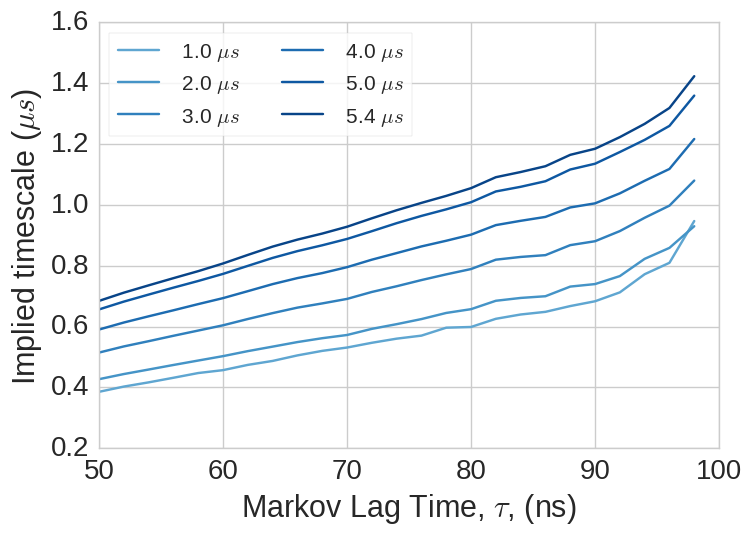

In [33]:
n = tscales.shape[1]*2
to_mu = to_ns/1000
cols = sns.color_palette('Blues', n)
with sns.plotting_context('notebook', font_scale=2):
    sns.set_style('whitegrid')
    fig, ax = plt.subplots()
    for idx in range(len(trajs_idx)):
        time = trajs_idx[idx]*n_frames*to_mu/(2)
        ax.plot(lags*to_ns, tscales.T[idx]*to_mu, c=cols[int(n/2) + idx], label='{0:4.1f} $\mu s$'.format(time))
    ax.legend(frameon=True, framealpha=0.8, ncol=2, fontsize=15, loc=2)
    ax.set_xlabel(r'Markov Lag Time, $\tau$, (ns)')
    ax.set_ylabel(r'Implied timescale ($\mu s$)')
#     ax.set_yscale('log')
plt.savefig('Lag-time-convergence.pdf')

In [41]:
from msmbuilder.msm import MarkovStateModel
msm = MarkovStateModel(n_timescales=1, lag_time=int(90/to_ns))
msm.fit(ctrajs)

MSM contains 1 strongly connected component above weight=0.00. Component 0 selected, with population 100.000000%


MarkovStateModel(ergodic_cutoff='on', lag_time=9000, n_timescales=1,
         prior_counts=0, reversible_type='mle', sliding_window=True,
         verbose=True)

## Lump states using PCCA

In [42]:
from msmbuilder.lumping import PCCAPlus
pcca = PCCAPlus.from_msm(msm, n_macrostates=2)
macro_trajs = pcca.transform(ctrajs, mode='fill')


Optimization terminated successfully.
         Current function value: -1.902403
         Iterations: 9
         Function evaluations: 26


(-0.1, 1.1)

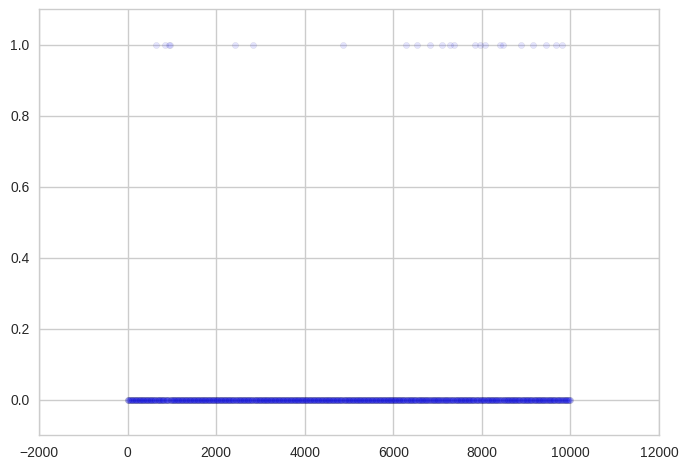

In [36]:
trajn = 1
plt.scatter(np.arange(macro_trajs[trajn].shape[0])[::10],macro_trajs[trajn][::10], alpha=0.1)
plt.ylim((-0.1,1.1))

## Plot O-H distances and cluster


In [43]:
macro = np.concatenate(macro_trajs)
macro.shape


(1080000,)

In [78]:
total_traj = md.join(traj for traj in trajs)

In [79]:
total_traj = total_traj.superpose(total_traj)

In [80]:
for state in range(2):
    inds = np.where(macro==state)[0]
    sample_inds = np.random.choice(inds, 200)
    traj = md.join(total_traj[i] for i in sample_inds)
    traj.save("{}/{}.nc".format('trajectories', state))

In [81]:
import pandas as pd
all_dfs = []

for i in [0,1]:
    p1 = total_traj.topology.select("(resname TTW and name HI{}) or (resname ASP and name OD1)".format(2))
    p2 = total_traj.topology.select("(resname TTW and name HI{}) or (resname ASP and name OD2)".format(2))
    pairs = np.array([p1, p2])
    distances = md.compute_distances(total_traj, pairs)*10 # Nanometers to Angstroms
    df = pd.DataFrame(data=distances, columns=['OD1','OD2'])
    df['PCCA_state'] = i
    df['H-donor'] = 'HI{}'.format(2)
    df = pd.melt(frame=df, id_vars=['PCCA_state', 'H-donor'], var_name='H-acceptor', value_name='Distance')
    all_dfs.append(df)

df = pd.concat(all_dfs)
df.head()

,PCCA_state,H-donor,H-acceptor,Distance
0,0,HI2,OD1,7.757235
1,0,HI2,OD1,6.927047
2,0,HI2,OD1,7.726332
3,0,HI2,OD1,8.285743
4,0,HI2,OD1,8.093565


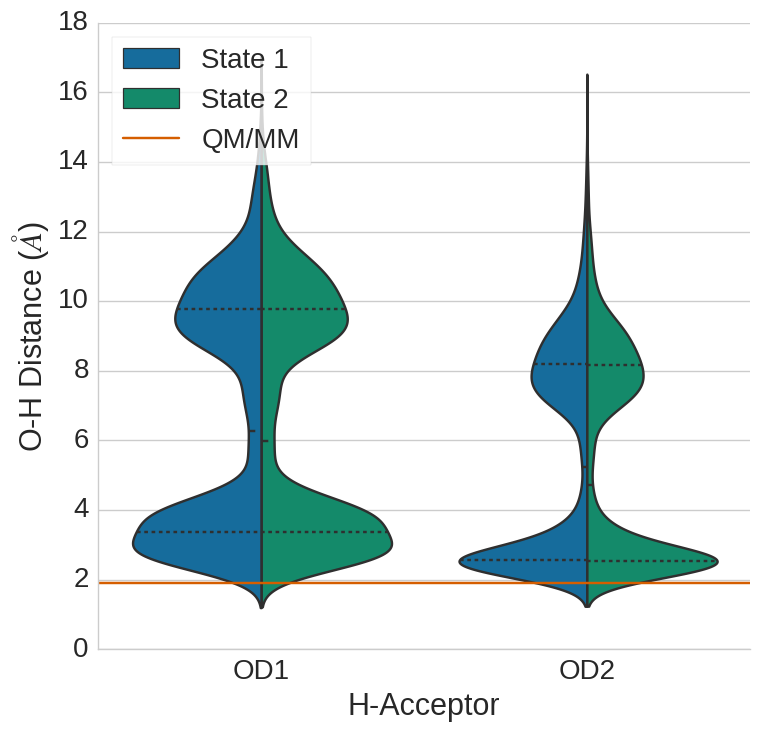

In [82]:
hod2 = 1.9
sample = df.sample(n=100000)
with sns.plotting_context('notebook', font_scale=2):
    sns.set_style('whitegrid')
    cols = sns.color_palette('colorblind', 3)
    grid = sns.FacetGrid(sample, col='H-donor',size=8, legend_out=False, )
    grid = grid.map(sns.violinplot, 'H-acceptor' , 'Distance','PCCA_state', palette=cols[:2], alpha=0.5, 
                     inner='quartile', gridsize=1000, split=True)
    for ax in grid.axes.flatten():
        ax.hlines(hod2, xmin=-1, xmax=2.5, colors=cols[-1], label='QM/MM')
    
    handles, labels = grid.axes.flatten()[0].get_legend_handles_labels()
    new_labels = ['State {}'.format(int(x)+1) for x in labels[:2]]
    new_labels = new_labels + [labels[-1]]
    
    grid.axes.flatten()[0].legend(loc=2, labels=new_labels, handles=handles, 
                                 frameon=True, framealpha=0.8)#, bbox_to_anchor=(1.7,1.1))
    grid.set_ylabels(r'O-H Distance ($\AA$)')
    grid.set_xlabels('H-Acceptor')
    grid.set_titles("")
#     grid.set(ylim=(0,12))

plt.savefig('OH_distance.pdf')
